In [1]:
import sys
import os
# Get the current working directory (the directory where the notebook is located)
current_dir = os.getcwd()
# Get the path of the parent directory (one level up)
parent_dir = os.path.dirname(current_dir)
# Change the working directory to the parent directory
os.chdir(parent_dir)

import json
import pandas as pd
import numpy as np
from datetime import datetime
import re
import cv2
from tools.read_jsons import * # read_jsons.py
from tools.get_image_files import * # get_image_files.py
from tools.image_analysis import * # image_analysis.py
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# station_name = 'oakisland_west'
station_name = 'jennette_north'
# station_name = 'currituck_hampton_inn'
getImg = GetImages(station_name)
print(getImg.get_image_dir()) # get the image directory
getImg.get_image_dir() # get the image directory
getImg.set_image_type('timex') # set the image type
getImg.get_image_list()[:3] # get the image list
getImg.parse_image_datetime()[:3] # parse the image datetime
getImg.create_image_df() # create the image dataframe
# print(f"Total images in {station_name} directory:\n{getImg.image_df.info()}")

# import a subset of images
dt_range = getImg.get_date_range('2024-07-14 00:00:00', '2024-07-15 00:00:00') # get the date range
# dt_range = getImg.get_date_range() # get the date range
getImg.get_image_range(dt_range) # get the image range
# print(f"Images in Date Range:\n{getImg.image_range}")

# get images for analysis
# Note that images are imported with opencv2 and are Blue-Green-Red (BGR) format
# Plotting in matplotlib requires converting to Red-Green-Blue (RGB) format (cv2.COLOR_BGR2RGB)
imgs = getImg.get_images() # get the images

images/jennette_north/


Note: first timestamp image in the date range we are considering is of poor quality due to early morning conditions. We leave it in the dataset for training at this time so as to learn how to deal with such challenges in production.

In [3]:
IA = ImageAnalysis(imgs, getImg.image_range.copy()) # image analysis
IA.get_image_means() # get the image
print(IA.img_dict.keys()) # image dictionary
img_dates = list(IA.img_dict.keys()) # image dates
print(f"First image in dictionary:\n{type(IA.img_dict[img_dates[1]])}") # first image in dictionary
print(f"Image Dataframe:\n") # image dataframe
IA.image_df.head()

dict_keys(['2024-07-14 10:05:21', '2024-07-14 11:05:22', '2024-07-14 11:59:50', '2024-07-14 12:58:14', '2024-07-14 13:34:05', '2024-07-14 14:34:04', '2024-07-14 15:34:11', '2024-07-14 16:24:28', '2024-07-14 17:04:42', '2024-07-14 17:39:01', '2024-07-14 18:30:58', '2024-07-14 19:25:41', '2024-07-14 20:25:41', '2024-07-14 21:09:05', '2024-07-14 22:04:55', '2024-07-14 22:48:18', '2024-07-14 23:34:16'])
First image in dictionary:
<class 'numpy.ndarray'>
Image Dataframe:



,Image,blue,green,red
Datetime,,,,
2024-07-14 10:05:21,jennette_north-2024-07-14-100521Z-timex.jpeg,130.350202,130.350202,130.350202
2024-07-14 11:05:22,jennette_north-2024-07-14-110522Z-timex.jpeg,149.291201,145.357654,135.629364
2024-07-14 11:59:50,jennette_north-2024-07-14-115950Z-timex.jpeg,137.007906,125.084313,111.003728
2024-07-14 12:58:14,jennette_north-2024-07-14-125814Z-timex.jpeg,132.027393,122.987593,111.075622
2024-07-14 13:34:05,jennette_north-2024-07-14-133405Z-timex.jpeg,140.401645,129.672752,116.920742


In [4]:
# IA.set_ROI(0, 0, 1200, 600) # set region of interest (x1, y1, x2, y2)
IA.set_ROI(0, 300, 1200, 600) # set region of interest (x1, y1, x2, y2)
grid_size = 100
img_segs = IA.segment_images(grid_size=grid_size) # segment the images
print(f"With image size {IA.img_dict[img_dates[1]].shape} and gridsize {grid_size}, there are {len(img_segs['2024-07-14 10:05:21'].keys())} segments.") # segmented image data
# print(f"Segmented image data:\n{img_segs['2024-07-14 10:05:21']['region_0_0']}") # segmented image data
IA.add_bgr_stats() # add BGR stats

With image size (1944, 2592, 3) and gridsize 100, there are 36 segments.


In [5]:
IA.get_segmented_dataframe() # get the segmented dataframe

,Date,Region,Region_Array,Max_BGR,Avg_BGR,Median_BGR
0,2024-07-14 10:05:21,region_0_0,"[[[69, 69, 69], [69, 69, 69], [69, 69, 69], [7...","(101, 101, 101)","(75.7164, 75.7164, 75.7164)","(75.0, 75.0, 75.0)"
1,2024-07-14 10:05:21,region_0_1,"[[[89, 89, 89], [89, 89, 89], [89, 89, 89], [8...","(95, 95, 95)","(74.7633, 74.7633, 74.7633)","(77.0, 77.0, 77.0)"
2,2024-07-14 10:05:21,region_0_2,"[[[48, 48, 48], [48, 48, 48], [50, 50, 50], [5...","(115, 115, 115)","(84.4775, 84.4775, 84.4775)","(85.0, 85.0, 85.0)"
3,2024-07-14 10:05:21,region_0_3,"[[[77, 77, 77], [76, 76, 76], [75, 75, 75], [7...","(133, 133, 133)","(90.5156, 90.5156, 90.5156)","(92.0, 92.0, 92.0)"
4,2024-07-14 10:05:21,region_0_4,"[[[82, 82, 82], [81, 81, 81], [82, 82, 82], [8...","(139, 139, 139)","(109.5747, 109.5747, 109.5747)","(110.0, 110.0, 110.0)"
...,...,...,...,...,...,...
607,2024-07-14 23:34:16,region_2_7,"[[[127, 132, 131], [127, 132, 131], [129, 134,...","(182, 172, 167)","(145.0712, 141.5812, 136.9222)","(149.0, 146.0, 140.0)"
608,2024-07-14 23:34:16,region_2_8,"[[[146, 147, 145], [146, 147, 145], [146, 147,...","(156, 153, 150)","(151.3631, 148.3874, 143.8922)","(152.0, 149.0, 145.0)"
609,2024-07-14 23:34:16,region_2_9,"[[[134, 127, 118], [134, 127, 118], [136, 129,...","(154, 151, 149)","(140.8109, 136.9441, 131.736)","(141.0, 137.0, 132.0)"
610,2024-07-14 23:34:16,region_2_10,"[[[142, 130, 112], [141, 129, 111], [141, 129,...","(152, 145, 140)","(133.6432, 129.5692, 125.8997)","(132.0, 129.0, 126.0)"


In [6]:
# drop the region array column
df = IA.segmented_dataframe.drop(columns=['Region_Array']).copy()
df.iloc[-25:,:]

,Date,Region,Max_BGR,Avg_BGR,Median_BGR
587,2024-07-14 23:34:16,region_0_11,"(189, 165, 150)","(160.1206, 143.7504, 125.5881)","(158.0, 142.0, 125.0)"
588,2024-07-14 23:34:16,region_1_0,"(153, 151, 147)","(112.0688, 110.2943, 103.8252)","(130.0, 127.0, 122.0)"
589,2024-07-14 23:34:16,region_1_1,"(168, 166, 163)","(114.992, 114.6318, 110.6622)","(126.0, 127.0, 125.0)"
590,2024-07-14 23:34:16,region_1_2,"(160, 160, 157)","(125.9308, 126.2866, 122.5178)","(135.0, 134.0, 131.0)"
591,2024-07-14 23:34:16,region_1_3,"(159, 161, 155)","(136.6429, 136.8411, 133.4855)","(140.0, 139.0, 136.0)"
592,2024-07-14 23:34:16,region_1_4,"(174, 177, 175)","(141.6563, 142.1553, 139.9294)","(143.0, 144.0, 142.0)"
593,2024-07-14 23:34:16,region_1_5,"(168, 169, 163)","(142.3374, 144.3741, 142.3365)","(144.0, 145.0, 143.0)"
594,2024-07-14 23:34:16,region_1_6,"(157, 162, 161)","(140.4163, 144.1967, 142.9695)","(140.0, 145.0, 144.0)"
595,2024-07-14 23:34:16,region_1_7,"(151, 156, 155)","(132.553, 136.0988, 135.5342)","(136.0, 140.0, 140.0)"
596,2024-07-14 23:34:16,region_1_8,"(149, 150, 149)","(135.2571, 134.1407, 132.2753)","(137.0, 136.0, 134.0)"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        612 non-null    object
 1   Region      612 non-null    object
 2   Max_BGR     612 non-null    object
 3   Avg_BGR     612 non-null    object
 4   Median_BGR  612 non-null    object
dtypes: object(5)
memory usage: 24.0+ KB


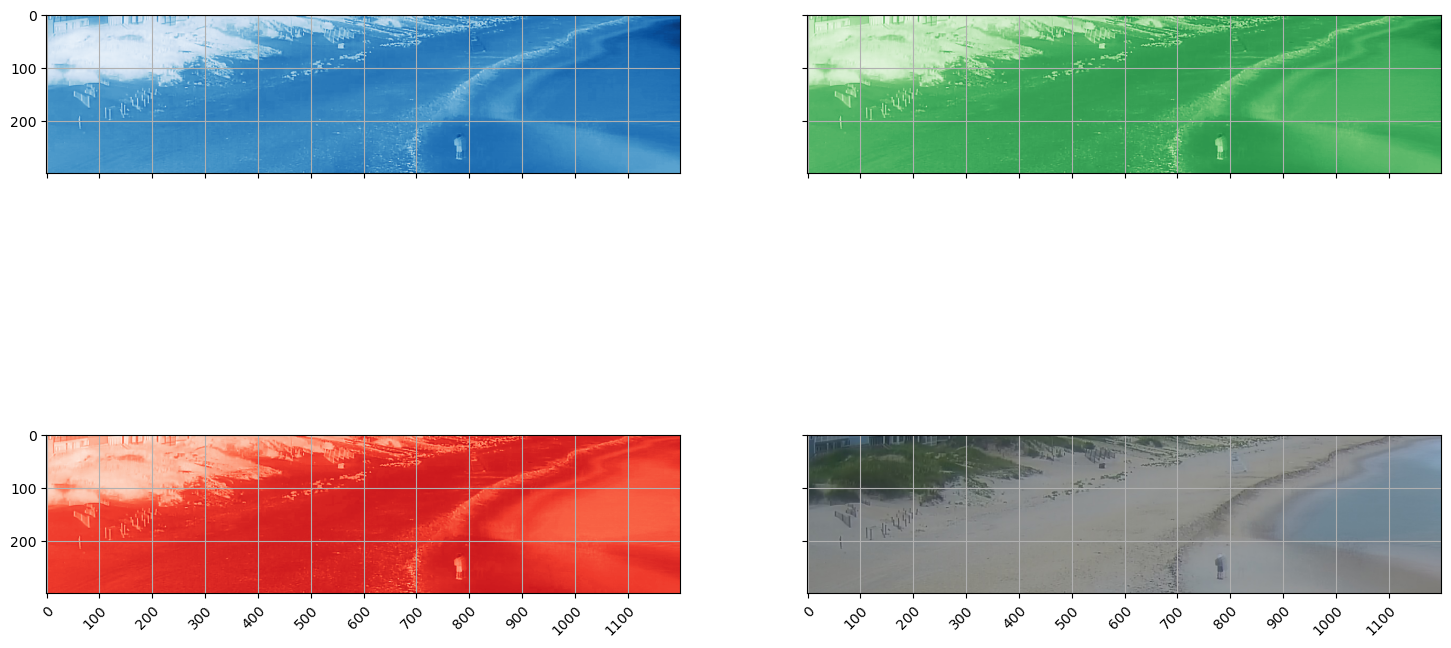

In [8]:
IA.plot_image_grid(img_date="2024-07-14 23:34:16")

In [9]:
IA.plot_bgr_clusters()

# Labeling and Weighting

For each region of interest in segmentation $(i,j)$ we obtain weighted vectors:

$$ROI_{ij} = (\%sand, \%water, \%vegetation)$$

We will begin with a simple method for labeling by using the % of each type of BGR value in a region.
- `Sand`: pixels are labeled sand (S) if they have roughly equal proportions of each BGR value.
- `Water`: pixels labeled as water (W) will have B>G>R (or, weakly, B>R>G)
- `Vegetation`: pixels labeled as vegetation (V) will have G>B>R
These inequalities will all depend on specified thresholds. Note we can also use machine learning techniques to determine such boundaries (classifiers like KNN, SVM, or CNNs for more complex classification tasks).

Next we add labels,
- `Shoreline` ~ cluster on sand/ocean weights for region label (Sh)
- `Sand` ~ purely dominated by %sand weight for region label (Sd)
- `Ocean` ~ purely dominated by %weight weight for region label (Ocn)
- `Dune` ~ significant non-zero value of vegetation (V) for region label (Du)

## Test Metric #1
### Pixel Weight - Sand (S)
`Sand`: for tuple $(B,G,R)$ shift all elements by one to $(R,B,G)$ and difference with the resulting thresholding tuple 
$$T = abs((B-R,G-B,R-G))$$
of values. Suppose we have a threshold `lambda` ($\lambda$) such that for each element $t \in T$ we have $t \le\lambda$. A method for finding a good lambda at a given station would be to select a region, or regions, which are strictly sand and observe the boundary (distribribution) of the tresholding tuple space. (This can probably be posed as some sort of eigenvalue or SVD type of matrix problem)
### Pixel Weight - Water (W)
`Water`: for threshold $\lambda$, if  $B-G > B-R > \lambda$, we label a pixel water (W). Put another way, the space defined by $(B-G-\lambda) \times (B-R-\lambda)$ is positive definite.
### Pixel Weight - Vegetation (V)
`Vegetation`: for threshold $\lambda$, if $G-R>\lambda$ and $G>B$, then we label the pixel vegetation (V)

### Noted Issue with the above method.
The lambda boundary presents problems on BGR 255 scale when distinguishing between low and high pixel value mixtures. For instance $\lambda = 8$ is too relaxed for labeling sand pixels under low reflectance and/or pixel value tuples such as $(232,231,224)$ and $(88,83,76)$.

Added color_normization and kernel methods. It might be better to create a filter for each sand, veg, and ocean. Need to test color spacer transformation function.

Sand Pixels: 2559
Percentage of Sand Pixels: 25.59%
Shape of final mask: (100, 100)
Vegetation Pixels: 6052
Percentage of Vegetation Pixels: 60.52%
Water Pixels: 1
Percentage of Water Pixels: 0.01%
Region shape: (100, 100, 3)


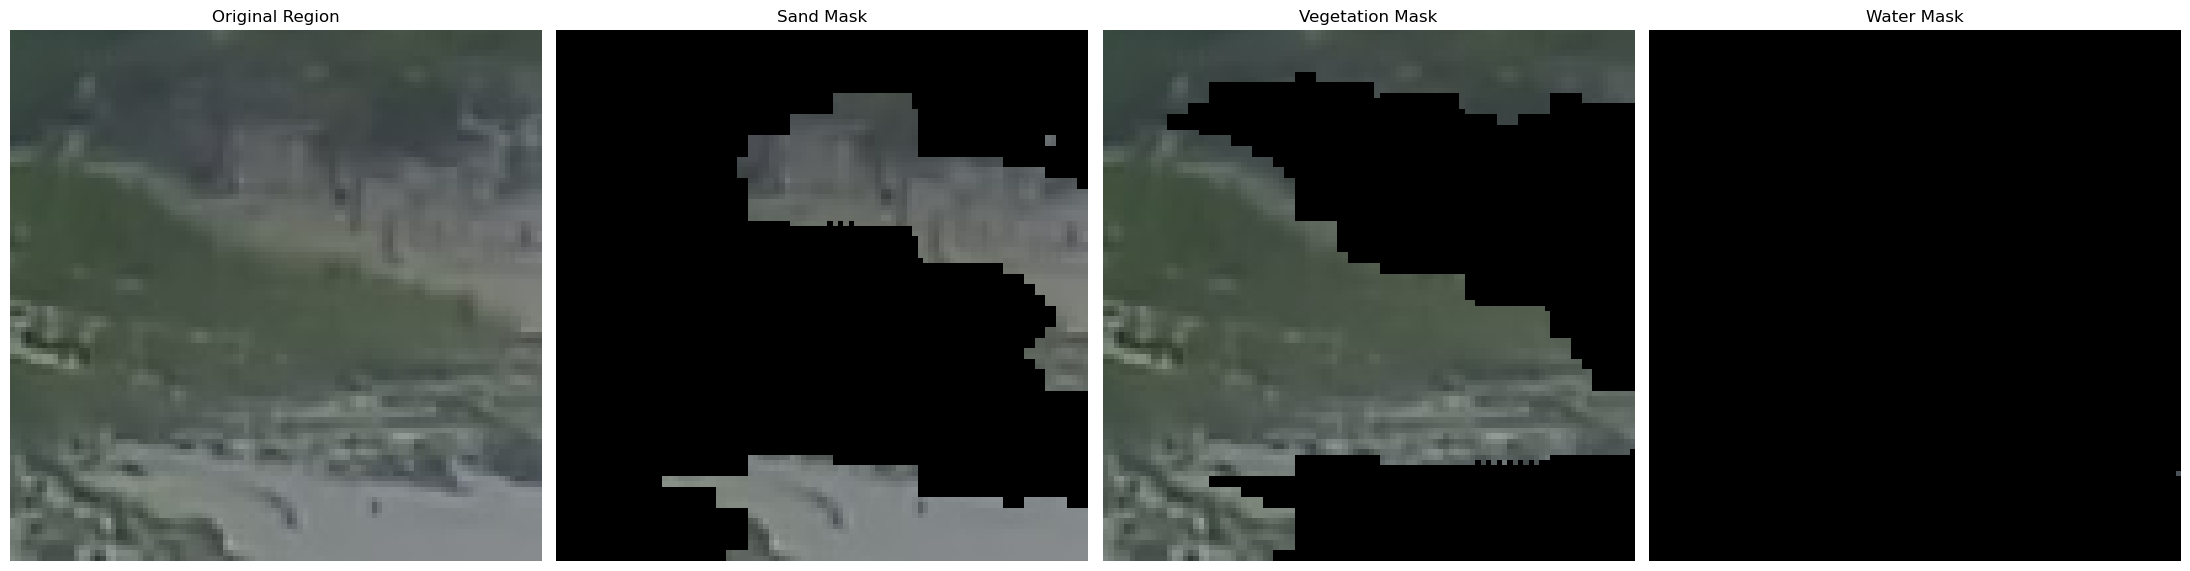

In [10]:
# test pixel sand mask calculation
# test with region_0_4 on 2024-07-14 23:34:16
test_roi = IA.segmented_dataframe[(IA.segmented_dataframe["Region"] == "region_0_3") & (IA.segmented_dataframe["Date"] == "2024-07-14 23:34:16")].copy()
test_roi = test_roi["Region_Array"]
# get the region array
test_roi = test_roi.values[0]
# print(f"Test ROI:\n{test_roi}")
sand_mask = IA.pixel_sand(test_roi, lambda_val=8)
veg_mask = IA.pixel_vegetation(test_roi, lambda_val=8)
water_mask = IA.pixel_water(test_roi, lambda_val=12)
IA.plot_SVW_mask(test_roi)

Sand Pixels: 9120
Percentage of Sand Pixels: 91.20%
Shape of final mask: (100, 100)
Vegetation Pixels: 880
Percentage of Vegetation Pixels: 8.80%
Water Pixels: 0
Percentage of Water Pixels: 0.00%
Region shape: (100, 100, 3)


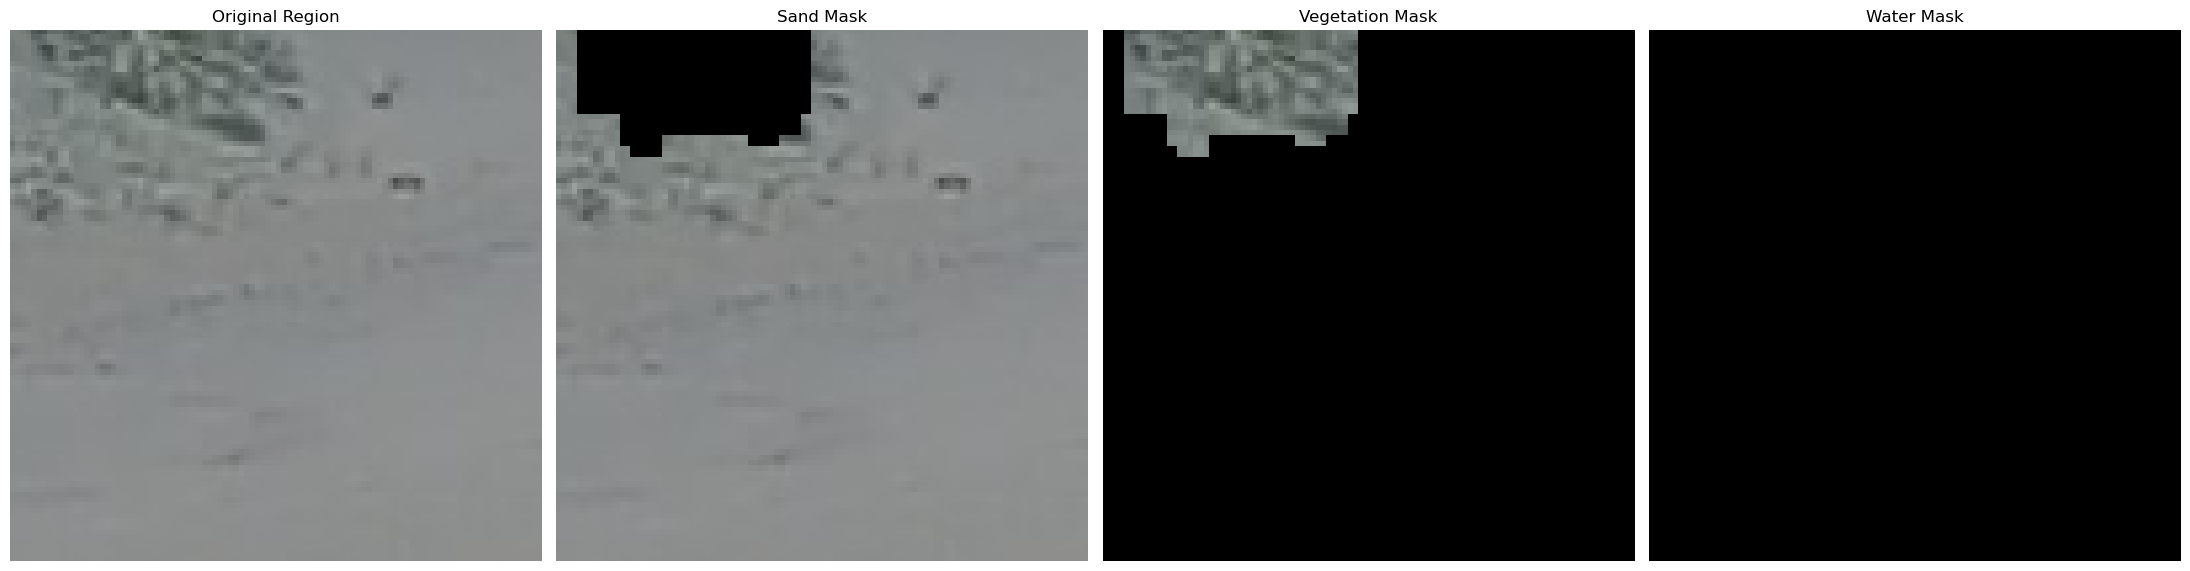

In [11]:
# test pixel sand mask calculation
# test with region_0_4 on 2024-07-14 23:34:16
test_roi = IA.segmented_dataframe[(IA.segmented_dataframe["Region"] == "region_1_3") & (IA.segmented_dataframe["Date"] == "2024-07-14 23:34:16")].copy()
test_roi = test_roi["Region_Array"]
# get the region array
test_roi = test_roi.values[0]
# print(f"Test ROI:\n{test_roi}")
sand_mask_r13 = IA.pixel_sand(test_roi, lambda_val=8)
veg_mask_r13 = IA.pixel_vegetation(test_roi, lambda_val=8)
water_mask_r13 = IA.pixel_water(test_roi, lambda_val=12)
IA.plot_SVW_mask(test_roi)

Sand Pixels: 4263
Percentage of Sand Pixels: 42.63%
Shape of final mask: (100, 100)
Vegetation Pixels: 0
Percentage of Vegetation Pixels: 0.00%
Water Pixels: 4799
Percentage of Water Pixels: 47.99%
Region shape: (100, 100, 3)


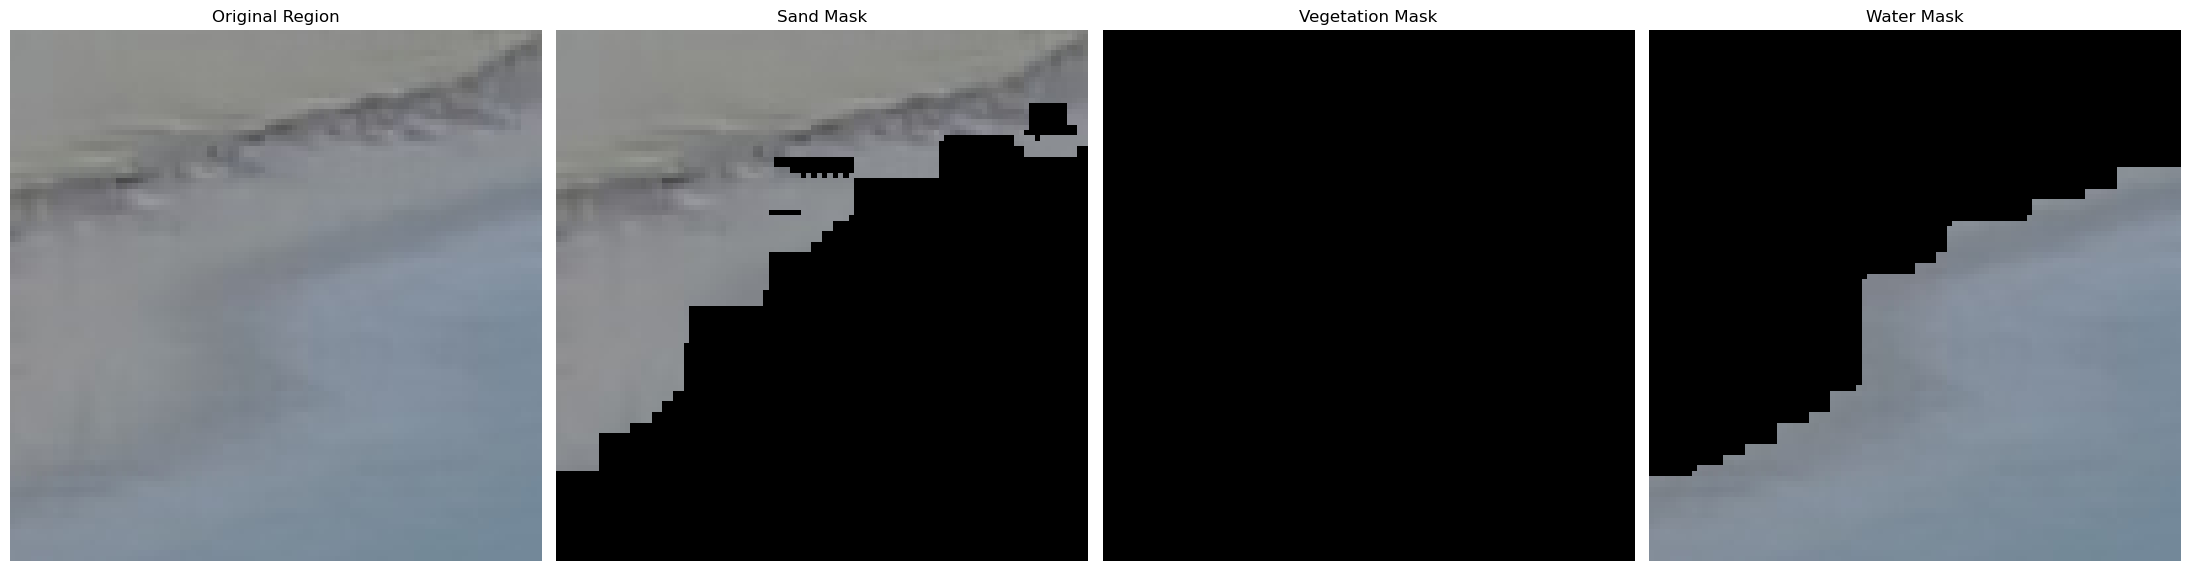

In [12]:
# test pixel sand mask calculation
# test with region_0_4 on 2024-07-14 23:34:16
test_roi = IA.segmented_dataframe[(IA.segmented_dataframe["Region"] == "region_0_10") & (IA.segmented_dataframe["Date"] == "2024-07-14 23:34:16")].copy()
test_roi = test_roi["Region_Array"]
# get the region array
test_roi = test_roi.values[0]
# print(f"Test ROI:\n{test_roi}")
sand_mask_r010 = IA.pixel_sand(test_roi, lambda_val=8)
veg_mask_r010 = IA.pixel_vegetation(test_roi, lambda_val=8)
water_mask_r010 = IA.pixel_water(test_roi, lambda_val=12)
IA.plot_SVW_mask(test_roi)

### Sand-Vegetation-Water Region Labels

In [13]:
svw_df = IA.swv_vectorization()

Sand Pixels: 10000
Percentage of Sand Pixels: 100.00%
Shape of final mask: (100, 100)
Vegetation Pixels: 0
Percentage of Vegetation Pixels: 0.00%
Water Pixels: 0
Percentage of Water Pixels: 0.00%
Sand Pixels: 10000
Percentage of Sand Pixels: 100.00%
Shape of final mask: (100, 100)
Vegetation Pixels: 0
Percentage of Vegetation Pixels: 0.00%
Water Pixels: 0
Percentage of Water Pixels: 0.00%
Sand Pixels: 10000
Percentage of Sand Pixels: 100.00%
Shape of final mask: (100, 100)
Vegetation Pixels: 0
Percentage of Vegetation Pixels: 0.00%
Water Pixels: 0
Percentage of Water Pixels: 0.00%
Sand Pixels: 10000
Percentage of Sand Pixels: 100.00%
Shape of final mask: (100, 100)
Vegetation Pixels: 0
Percentage of Vegetation Pixels: 0.00%
Water Pixels: 0
Percentage of Water Pixels: 0.00%
Sand Pixels: 10000
Percentage of Sand Pixels: 100.00%
Shape of final mask: (100, 100)
Vegetation Pixels: 0
Percentage of Vegetation Pixels: 0.00%
Water Pixels: 0
Percentage of Water Pixels: 0.00%
Sand Pixels: 10000
P

In [14]:
# drop Region_Array column
svw_df = svw_df.drop(columns=['Region_Array']).copy()

In [15]:
svw_df.tail(25)

,Date,Region,Max_BGR,Avg_BGR,Median_BGR,SVW
587,2024-07-14 23:34:16,region_0_11,"(189, 165, 150)","(160.1206, 143.7504, 125.5881)","(158.0, 142.0, 125.0)","(3.6900000000000004, 0.0, 94.12)"
588,2024-07-14 23:34:16,region_1_0,"(153, 151, 147)","(112.0688, 110.2943, 103.8252)","(130.0, 127.0, 122.0)","(55.16, 14.37, 24.44)"
589,2024-07-14 23:34:16,region_1_1,"(168, 166, 163)","(114.992, 114.6318, 110.6622)","(126.0, 127.0, 125.0)","(81.8, 9.959999999999999, 2.5700000000000003)"
590,2024-07-14 23:34:16,region_1_2,"(160, 160, 157)","(125.9308, 126.2866, 122.5178)","(135.0, 134.0, 131.0)","(86.1, 6.819999999999999, 3.08)"
591,2024-07-14 23:34:16,region_1_3,"(159, 161, 155)","(136.6429, 136.8411, 133.4855)","(140.0, 139.0, 136.0)","(91.2, 8.799999999999999, 0.0)"
592,2024-07-14 23:34:16,region_1_4,"(174, 177, 175)","(141.6563, 142.1553, 139.9294)","(143.0, 144.0, 142.0)","(100.0, 0.16, 0.0)"
593,2024-07-14 23:34:16,region_1_5,"(168, 169, 163)","(142.3374, 144.3741, 142.3365)","(144.0, 145.0, 143.0)","(100.0, 4.64, 0.0)"
594,2024-07-14 23:34:16,region_1_6,"(157, 162, 161)","(140.4163, 144.1967, 142.9695)","(140.0, 145.0, 144.0)","(100.0, 1.76, 0.0)"
595,2024-07-14 23:34:16,region_1_7,"(151, 156, 155)","(132.553, 136.0988, 135.5342)","(136.0, 140.0, 140.0)","(100.0, 6.16, 0.0)"
596,2024-07-14 23:34:16,region_1_8,"(149, 150, 149)","(135.2571, 134.1407, 132.2753)","(137.0, 136.0, 134.0)","(87.02, 0.64, 11.05)"


### Custom Kernels for Pixel Classification

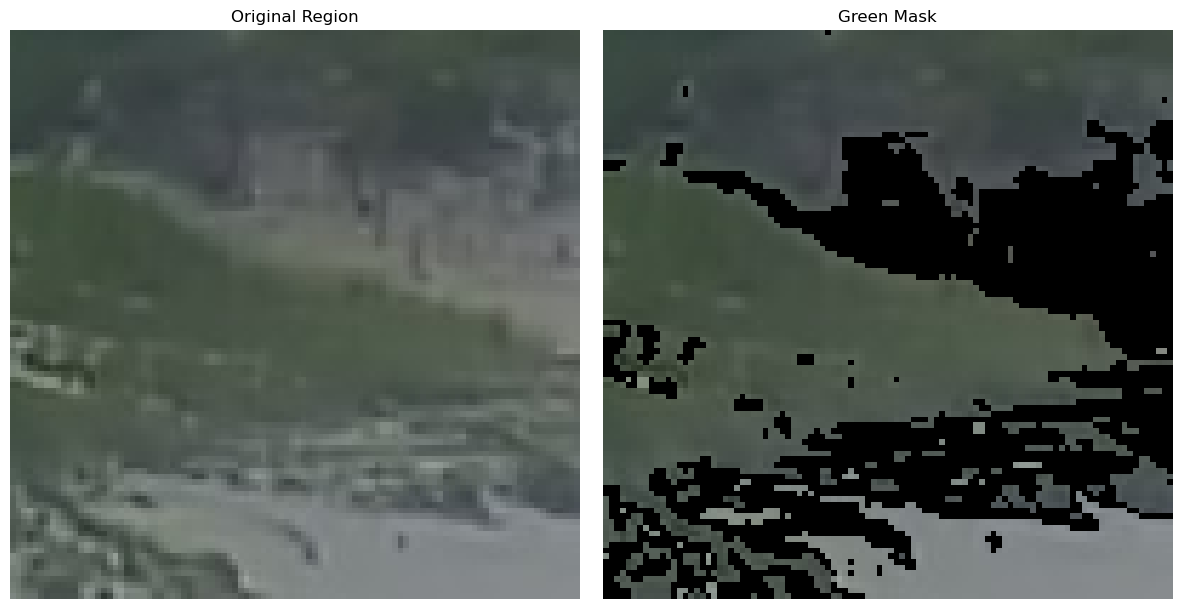

In [16]:

def custom_green_kernel(region, threshold=10):
    """
    Apply the custom K_green kernel to emphasize the green channel in a region.

    Parameters:
        region (numpy.ndarray): BGR region (H x W x 3).
        threshold (int): Threshold for green dominance.

    Returns:
        numpy.ndarray: Binary mask where green dominance is detected.
    """
    # Extract channels
    B, G, R = cv2.split(region)
    
    # Define the K_green kernel
    K_green = np.array([
        [0, 1, 0],
        [1, 2, 1],
        [0, 1, 0]
    ], dtype=np.float32)
    
    # Convolve the kernel with the green channel
    G_filtered = cv2.filter2D(G, -1, K_green)
    
    # Calculate local dominance: green compared to blue and red
    G_dominance = (G_filtered - B) + (G_filtered - R)
    
    # Create a mask for pixels with strong green dominance
    mask = G_dominance > threshold
    
    return mask.astype(np.uint8)

def plot_region_and_mask(region, mask, title="Green Mask"):
    """
    Plots the original region (converted to RGB) and the mask side by side.

    Parameters:
        region (numpy.ndarray): BGR region (H x W x 3).
        mask (numpy.ndarray): Binary mask (H x W).
        title (str): Title for the mask plot.
    """
    # Convert BGR to RGB for display
    rgb_region = cv2.cvtColor(region, cv2.COLOR_BGR2RGB)

    # Create a masked image by applying the mask
    masked_region = rgb_region.copy()
    masked_region[mask == 0] = 0  # Set non-masked pixels to black

    # Plot the original region and the masked region
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(rgb_region)
    axes[0].set_title("Original Region")
    axes[0].axis("off")

    axes[1].imshow(masked_region)
    axes[1].set_title(title)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
test_roi = IA.segmented_dataframe[(IA.segmented_dataframe["Region"] == "region_0_3") & (IA.segmented_dataframe["Date"] == "2024-07-14 23:34:16")].copy()
test_roi = test_roi["Region_Array"]
# get the region array
test_roi = test_roi.values[0]
region = test_roi
# region = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)  # Replace with actual BGR region
green_mask = custom_green_kernel(region, threshold=80)

# Visualize the result
# Plot the region and the green mask
plot_region_and_mask(region, green_mask)


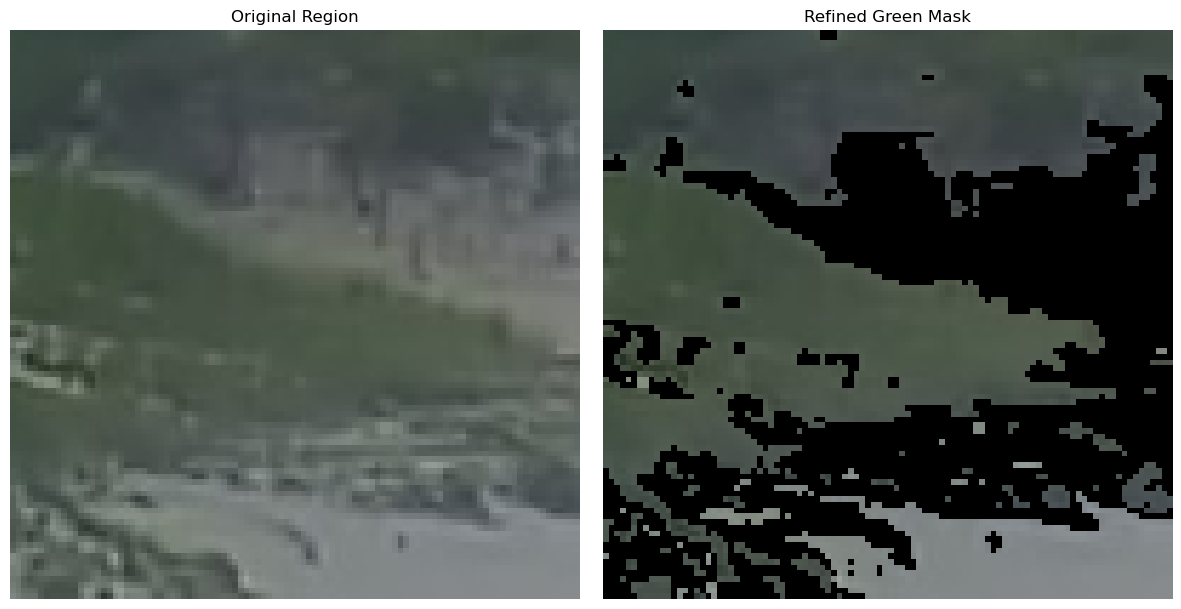

In [17]:
def refined_green_kernel(region, lambda1=10, lambda2=5):
    """
    Apply a refined kernel approach to distinguish vegetation from sand.

    Parameters:
        region (numpy.ndarray): BGR region (H x W x 3).
        lambda1 (int): Threshold for green dominance over other channels.
        lambda2 (int): Threshold to exclude sand misclassification.

    Returns:
        numpy.ndarray: Binary mask for vegetation detection (1 for vegetation, 0 for non-vegetation).
    """
    # Extract channels
    B, G, R = cv2.split(region)
    
    # Define the K_green kernel (fixed as 3x3)
    K_green = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ], dtype=np.float32)
    
    # Convolve the kernel with the green channel
    G_filtered = cv2.filter2D(G, -1, K_green)
    
    # Compute green dominance over red and blue channels
    G_dominance = (G_filtered - R) + (G_filtered - B)
    
    # Apply thresholding
    vegetation_mask = (G_dominance > lambda1) & (G_filtered > (R + B) / 2 + lambda2)
    
    # Return the binary mask
    return vegetation_mask.astype(np.uint8)


# Example usage
vegetation_mask = refined_green_kernel(region, lambda1=90, lambda2=75)

# Plot the results
plot_region_and_mask(region, vegetation_mask, title="Refined Green Mask")


### Color Normalization Methods

Sand Pixels: 3893
Percentage of Sand Pixels: 38.93%
Shape of final mask: (100, 100)
Vegetation Pixels: 5983
Percentage of Vegetation Pixels: 59.83%
Water Pixels: 112
Percentage of Water Pixels: 1.12%
Region shape: (100, 100, 3)


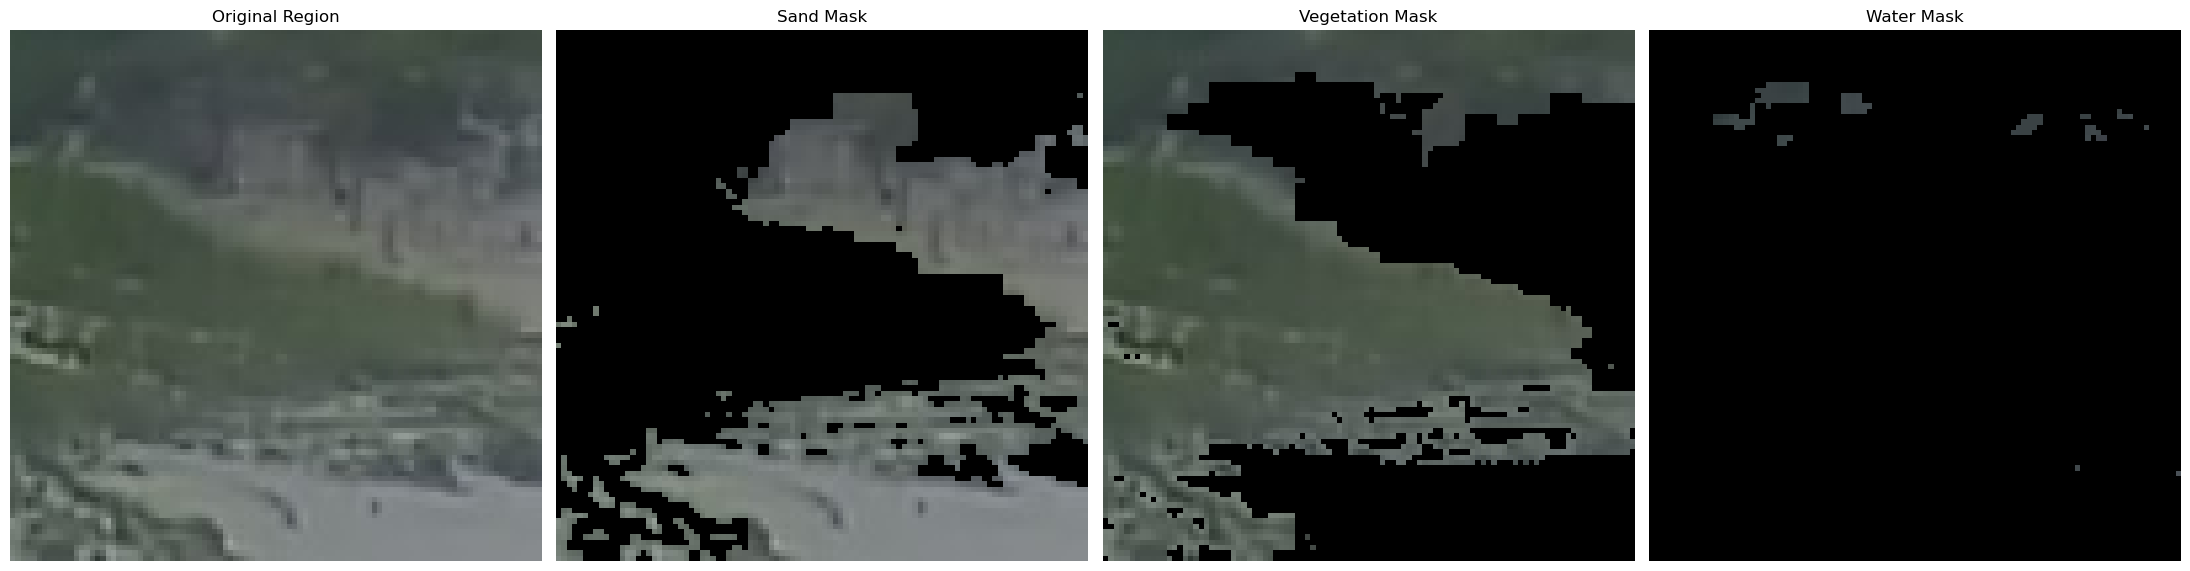

In [53]:
norm_region = IA.color_normalization(region, norm_type='l1')
norm_region = IA.color_normalization(region, norm_type='l1_w', weights=(0.3, 0.6, 0.1))
# norm_region = IA.color_normalization(region, norm_type='l2')
sand_mask = IA.pixel_sand(norm_region, lambda_val=0.10) # l1_w
veg_mask = IA.pixel_vegetation(norm_region, lambda_val=0.08) # l1_w
water_mask = IA.pixel_water(norm_region, lambda_val=0.15) # l1_w
# sand_mask = IA.pixel_sand(norm_region, lambda_val=0.03) # l1
# veg_mask = IA.pixel_vegetation(norm_region, lambda_val=0.03) # l1
# water_mask = IA.pixel_water(norm_region, lambda_val=0.075) # l1
IA.plot_SVW_mask(region)

In [49]:
norm_region

array([[[0.92240113, 1.068814  , 0.81991214],
        [0.92240113, 1.068814  , 0.81991214],
        [0.9212481 , 1.0698365 , 0.81723624],
        ...,
        [0.9370629 , 1.048951  , 0.8951049 ],
        [0.93793106, 1.0482758 , 0.8965517 ],
        [0.92032963, 1.0576923 , 0.89285713]],

       [[0.92352086, 1.067821  , 0.8225108 ],
        [0.92240113, 1.068814  , 0.81991214],
        [0.92240113, 1.068814  , 0.81991214],
        ...,
        [0.9370629 , 1.048951  , 0.8951049 ],
        [0.9370629 , 1.048951  , 0.8951049 ],
        [0.93793106, 1.0482758 , 0.8965517 ]],

       [[0.92352086, 1.067821  , 0.8225108 ],
        [0.92240113, 1.068814  , 0.81991214],
        [0.92240113, 1.068814  , 0.81991214],
        ...,
        [0.93793106, 1.0482758 , 0.8965517 ],
        [0.93793106, 1.0482758 , 0.8965517 ],
        [0.93793106, 1.0482758 , 0.8965517 ]],

       ...,

       [[0.9618573 , 1.0281923 , 0.9452736 ],
        [0.959507  , 1.0299295 , 0.9419014 ],
        [0.9513742 , 1

Sand Pixels: 2559
Percentage of Sand Pixels: 25.59%
Shape of final mask: (100, 100)
Vegetation Pixels: 6052
Percentage of Vegetation Pixels: 60.52%
Water Pixels: 205
Percentage of Water Pixels: 2.05%
Region shape: (100, 100, 3)


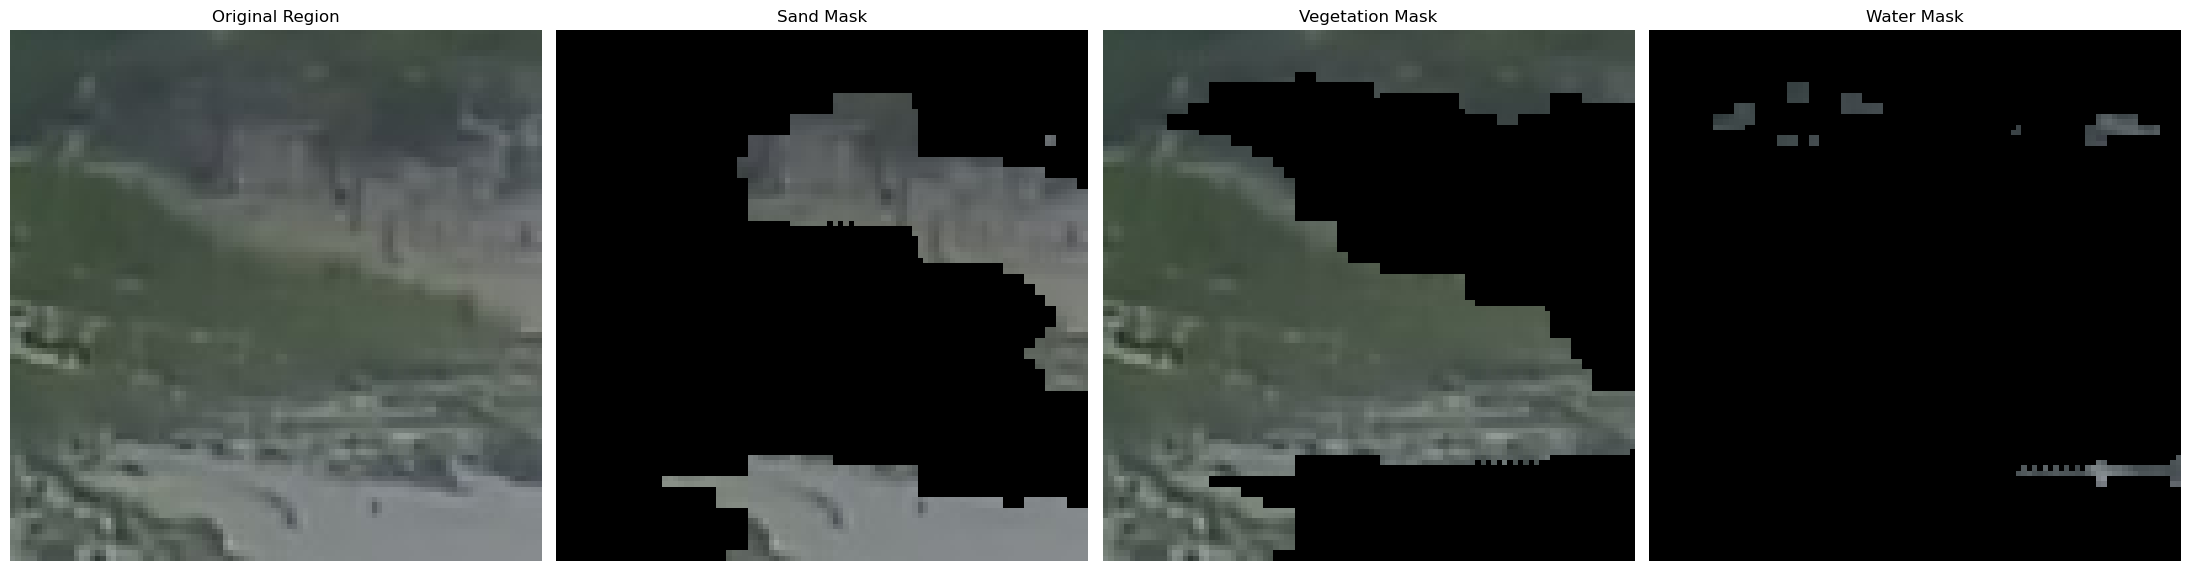

In [19]:
norm_region = IA.color_normalization(region, norm_type=None)
sand_mask = IA.pixel_sand(norm_region, lambda_val=8)
veg_mask = IA.pixel_vegetation(norm_region, lambda_val=8)
water_mask = IA.pixel_water(norm_region, lambda_val=10)
IA.plot_SVW_mask(region)

# Potential ML Models for pixel labeling.

Use supervised or unsupervised learning to learn the pixel weights:

- Train a classifier (e.g., SVM, Decision Tree, or Neural Network) using labeled data for sand, vegetation, and water pixels.
- Use clustering (e.g., k-means) in the (B−R,G−B,R−G) space to partition pixels without explicitly defining a lambda.